In [ ]:
%reset -f

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
##read excel
import pandas as pd
data_path = "/content/drive/MyDrive/sales-prediction/sales.xlsx"
df= pd.read_excel(data_path, engine='openpyxl')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248646 entries, 0 to 248645
Data columns (total 24 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Customer ID       246741 non-null  object 
 1   Customer Name     248646 non-null  object 
 2   Shipto Name       246741 non-null  object 
 3   Customer PO #     246741 non-null  object 
 4   Delivery Date     248646 non-null  object 
 5   Invoice Number    246741 non-null  object 
 6   Brand             171451 non-null  object 
 7   Item Description  248646 non-null  object 
 8   Itemcode          248646 non-null  int64  
 9   Packsize          171451 non-null  object 
 10  Quantity          248646 non-null  float64
 11  Total Sales       248646 non-null  float64
 12  G/SG              248646 non-null  object 
 13  Gropup            248646 non-null  object 
 14  Group Desc        248646 non-null  object 
 15  Group Name        248646 non-null  object 
 16  Group Name2       24

In [ ]:
## filter data

# Convert 'Delivery Date' to datetime
df['Delivery Date'] = pd.to_datetime(df['Delivery Date'], errors='coerce')
df = df.dropna(subset=['Delivery Date'])

# Extract the month and year from 'Delivery Date'
df['YearMonth'] = df['Delivery Date'].dt.to_period('M')



# Remove trailing whitespace from 'Item Description'
df['Item Description'] = df['Item Description'].str.strip()

# Extracting unique item codes and descriptions
item_dict = df.drop_duplicates(subset=['Itemcode']).set_index('Itemcode')['Item Description'].to_dict()

<ipython-input-5-f4b3ecaf0384>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['YearMonth'] = df['Delivery Date'].dt.to_period('M')
<ipython-input-5-f4b3ecaf0384>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Item Description'] = df['Item Description'].str.strip()


In [ ]:
# Assuming your DataFrame is named df

# Group by 'YearMonth' and 'Itemcode'
grouped = df.groupby(['YearMonth', 'Itemcode']).agg({
    'Item Description': 'first',
    'Quantity': 'sum',
    'Total Sales': 'sum'
}).reset_index()

# Sort the result by 'YearMonth' and 'Itemcode'
grouped = grouped.sort_values(by=['YearMonth', 'Itemcode'])

grouped
#810006 is 378269.10 in last

,YearMonth,Itemcode,Item Description,Quantity,Total Sales
0,2022-01,110001,Peeled Garlic 12x1 LB Garland,4302.0,201201.76
1,2022-01,110002,Peeled Garlic 12x3 LB Garland,1353.0,130804.60
2,2022-01,110004,Peeled Garlic 20x1 LB Garland,152.0,12527.00
3,2022-01,110005,Peeled Garlic 25 LB Commercial,109.0,3325.00
4,2022-01,110007,Peeled Garlic 30x6 OZ Garland,2074.0,102533.12
...,...,...,...,...,...
4031,2024-10,520012,Fresh Ginger 30lb PERU,88.0,3836.00
4032,2024-10,810002,Turmeric 12x5 OZ.,50.0,1424.00
4033,2024-10,810006,Fresh Ginger 10 LB - Box,7920.0,209336.60
4034,2024-10,810010,Fresh Ginger 20lb,68.0,3196.00


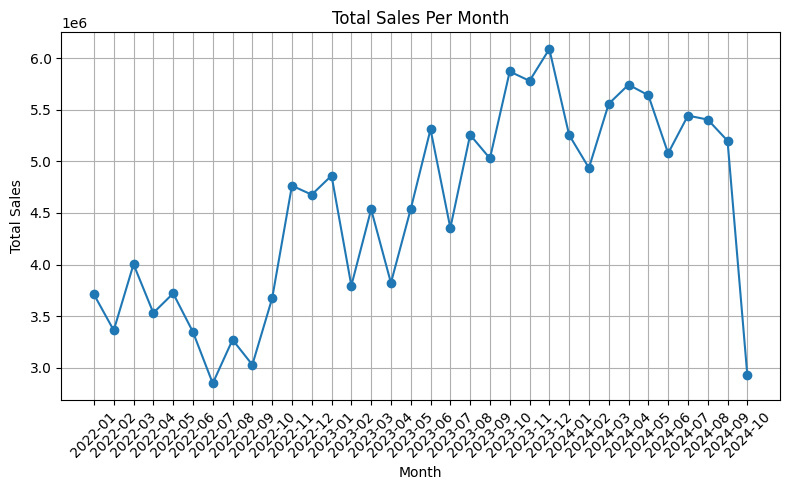

In [ ]:
import matplotlib.pyplot as plt

# Group the data by 'YearMonth' and sum the 'Total Sales'
monthly_sales = grouped.groupby('YearMonth')['Total Sales'].sum().reset_index()

# Plotting the data
plt.figure(figsize=(8, 5))
plt.plot(monthly_sales['YearMonth'].astype(str), monthly_sales['Total Sales'], marker='o')

plt.title('Total Sales Per Month')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
## prepare data




# Feature Scaling
item_id = 810006
item_data = grouped[grouped['Itemcode'] == item_id]
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(item_data[['Total Sales']])

# Define the number of time steps
time_steps = 12

# Prepare input-output sequences
def create_sequences(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

X, y = create_sequences(data_scaled, time_steps)
X = X.reshape((X.shape[0], X.shape[1], 1))


print(X.shape)
print(y.shape)




(20, 12, 1)
(20,)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout , Flatten



# Build more complex Dense model
model = Sequential()
model.add(Flatten(input_shape=(time_steps, 1)))  # Flatten the input
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')



# Train the model quietly
model.fit(X, y, epochs=500, batch_size=64)


Epoch 1/500


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.3835
Epoch 2/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2763
Epoch 3/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.2044
Epoch 4/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1496
Epoch 5/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0887
Epoch 6/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0754
Epoch 7/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0862
Epoch 8/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0681
Epoch 9/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.1111
Epoch 10/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1299
Epoch 11/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0712
Epoch 12/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1003
Epoch 13/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0306
Epoch 14/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1284
Epoch 15/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0782
Epoch 16/500
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


<ipython-input-27-9f9663e1c701>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  item_data['Predicted Sales'] = np.nan
<ipython-input-27-9f9663e1c701>:9: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a si

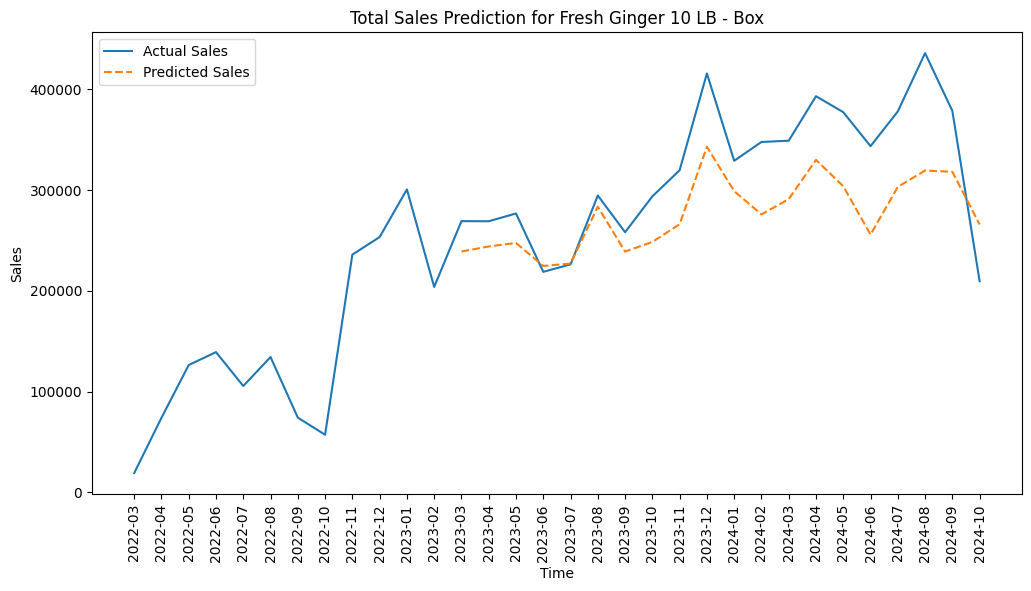

In [ ]:

# Predict
y_pred = model.predict(X)

# Inverse scale the predicted values
y_pred_inverse = scaler.inverse_transform(y_pred)

# Add predictions to your DataFrame
item_data['Predicted Sales'] = np.nan
item_data['Predicted Sales'].iloc[time_steps:] = y_pred_inverse.flatten()

# Plot results
import matplotlib.pyplot as plt


item_data['YearMonthStr'] = item_data['YearMonth'].astype(str)

plt.figure(figsize=(12, 6))
plt.plot(item_data['YearMonthStr'], item_data['Total Sales'], label='Actual Sales')
plt.plot(item_data['YearMonthStr'], item_data['Predicted Sales'], label='Predicted Sales', linestyle='--')
plt.title(f'Total Sales Prediction for {item_dict[item_id]}')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.xticks(rotation=90)
plt.legend()
plt.show()